In this project, we aim to understand  customers behavior across all brands about purchasing behavior from viewing the proudtc to adding it to the cart and purchasing it

We will explore the data to provide valuable insights and understand customer segmentation whether the product view is enough to maximize the profit or sales

The emphasis is on turning raw behavioral data into insights

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "2019-Oct.csv"

# Loading dataset with pandas kwargs
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mkechinov/ecommerce-behavior-data-from-multi-category-store",
    file_path,
    pandas_kwargs={
        "nrows": 900_000 # for this analysis we choose to only 500k rows
    }
)

/tmp/ipython-input-369695640.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'ecommerce-behavior-data-from-multi-category-store' dataset.


In [2]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


Dropping of unimportant columns

In [3]:
df = df.drop(['product_id', 'category_id', 'category_code', 'price','brand','user_session'],axis=1)


In [4]:
df.isna().sum()

,0
event_time,0
event_type,0
user_id,0


In [5]:
#data pre processing
import pandas as pd
df["event_time"] = pd.to_datetime(df["event_time"])

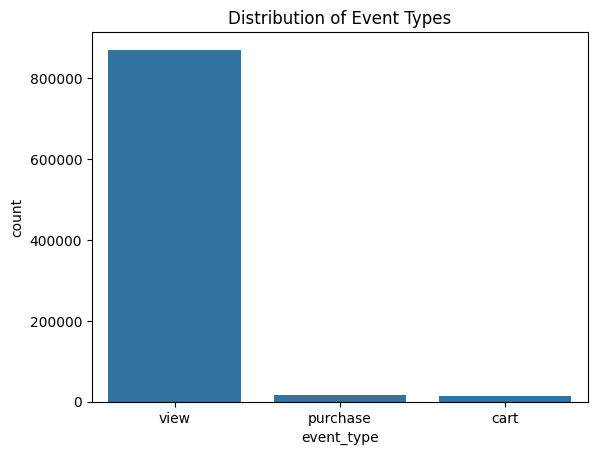

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='event_type')
plt.title('Distribution of Event Types')
plt.show()


Based on the initialgraph, we can see that most customer onlye view the product and only a small percentage are being added to their cart and being purchased

This represenation alone does nor truly explain the customer behavior for this dataset. As this data uses a unique user_id some customer might just revisit all over again and doing the same behavior, causing inflation to our count data

To solve this problem, we will be only accounting the first occurence of event types per customer id.

In [7]:
df = df.sort_values(["user_id", "event_time"]) #sorting it to lowest to highest as default
df = df.drop_duplicates(subset=["user_id","event_type"], keep="first") #dropping duplcates based on user id and the event type

df.head()

,event_time,event_type,user_id
387798,2019-10-01 08:47:35+00:00,view,244951053
1150,2019-10-01 01:32:09+00:00,view,306441847
563524,2019-10-01 11:20:46+00:00,view,315805600
511254,2019-10-01 10:32:50+00:00,view,318145786
187167,2019-10-01 05:55:19+00:00,view,321655812


In [8]:
view_count = df["event_type"] == "view"
cart_count = df["event_type"] == "cart"
purchase_count = df["event_type"] == "purchase"

df['event_type'].value_counts()

,count
event_type,
view,150470
purchase,11745
cart,7212


In [9]:
views_cart_dropoff= view_count.sum() - cart_count.sum()
cart_purchase_dropoff = cart_count.sum() - purchase_count.sum()

In [10]:
views_cart_dropoff /view_count.sum()*100

np.float64(95.2070180102346)

In [11]:
cart_purchase_dropoff /cart_count.sum()*100

np.float64(-62.85357737104825)

This is  still misleading. As we can see there are more count of purchase than count of cart, where in fact it's not logically correct since the ordering must be view->cart->purchase therefore purchase count cant be more than the cart count.

To solve this we will enforce a funnel order : views->cart-> urchase by pivoting by using user id as index with columns as the event type and values as the event_time

In [12]:
user_events = (
    df.pivot(index="user_id", columns="event_type", values="event_time")
)

user_events.head()

event_type,cart,purchase,view
user_id,,,
244951053,NaT,NaT,2019-10-01 08:47:35+00:00
306441847,NaT,NaT,2019-10-01 01:32:09+00:00
315805600,NaT,NaT,2019-10-01 11:20:46+00:00
318145786,NaT,NaT,2019-10-01 10:32:50+00:00
321655812,NaT,NaT,2019-10-01 05:55:19+00:00


In [13]:
# count views
view_users = user_events[user_events["view"].notna()]

# count of views that was added to cart
cart_users = view_users[view_users["cart"].notna()]

#  count of views to purchased
purchase_users = cart_users[cart_users["purchase"].notna()]

In [14]:
view_count= view_users.shape[0]
cart_count = cart_users.shape[0]
purchase_count = purchase_users.shape[0]


In [15]:
cart_count/view_count *100

4.789659068252808

In [16]:
purchase_count/cart_count *100

61.273761620646596

In [17]:
purchase_count/view_count *100

2.934804279922908

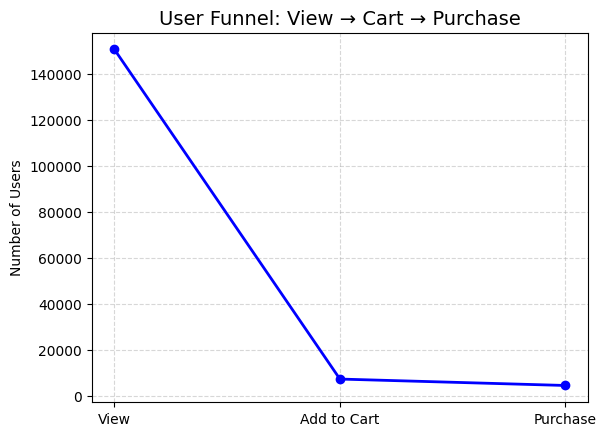

In [18]:
import matplotlib.pyplot as plt

stages = ["View", "Add to Cart", "Purchase"]
users = [view_count, cart_count, purchase_count]

plt.plot(stages, users, marker='o', linewidth=2, color='blue')

plt.title("User Funnel: View → Cart → Purchase", fontsize=14)
plt.ylabel("Number of Users")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


A huge drop off from customer who view the products to adding it to cart and purchasing it.

Calculated percentage shows that 4.8% of the product that was viewed are being added to cart and 61% of product that was added to cart are being purchased. In total  only about 3% of product that was being viewed are being purchased.

To better understand, we analyze the time taken by users to progress between these stages.

Longer delays may indicate hesitation, uncertainty, or lack of sufficient information at the product view stage

In [19]:
view_cart_users=cart_users.copy()
# Total time from view to cart
view_cart_users["time_to_cart"] = (view_cart_users["cart"] - view_cart_users["view"]).dt.total_seconds() / 60

# Total time from cart to purchase
cart_purchase_users=purchase_users.copy()
cart_purchase_users["time_to_purchase_from_cart"] = (cart_purchase_users["purchase"] - cart_purchase_users["cart"]).dt.total_seconds() / 60

# Total time from view to purchase
cart_purchase_users["time_to_view_to_purchase"] = (cart_purchase_users["purchase"] - cart_purchase_users["view"]).dt.total_seconds() / 60

In [20]:
view_cart_users = view_cart_users[view_cart_users["time_to_cart"] >0]
view_cart_users["time_to_cart"].describe()

,time_to_cart
count,7193.000000
mean,35.543862
std,100.157928
min,0.033333
25%,0.616667
50%,1.983333
75%,10.283333
max,929.400000


Half of the users in this dataset add the items to their cart in about 2 minutes.This suggest that half of customers often make fast decision as drawn by the product view.

However the distribution is long tail.With some users taking significantly longer to proceed. This indicates hesitation or delayed decision-making, potentially due to comparison behavior, uncertainty about pricing, or lack of sufficient product information.

In [21]:
cart_purchase_users = cart_purchase_users[cart_purchase_users["time_to_purchase_from_cart"] >0]
cart_purchase_users["time_to_purchase_from_cart"].describe()


,time_to_purchase_from_cart
count,4078.000000
mean,10.906433
std,45.182556
min,0.116667
25%,0.850000
50%,1.783333
75%,3.683333
max,708.516667


On this section we would see how long does it take to customer purchase the product after adding to the cart.

We can see that half of the customer quickly checks out the product in about 1.7 minutes. This indicates a clear decision from users that they are really eager to purchase the specifict product.

However it is still in long tail distribution and indicates some customers are still hesitant to purhcase the product even its on their cart already.

In [22]:
cart_purchase_users = cart_purchase_users[cart_purchase_users["time_to_view_to_purchase"] >0]
cart_purchase_users["time_to_view_to_purchase"].describe()

,time_to_view_to_purchase
count,4075.000000
mean,36.912536
std,96.331983
min,0.233333
25%,1.866667
50%,4.183333
75%,13.858333
max,792.866667


On this section we would see how long does it take to customer to complte the funnel stages (view-purchase)

We can observe a much more longer time here that half of the customers took  4 minutes to complete the process with a average of 22 minutes for all users

In [23]:
from matplotlib.cbook import normalize_kwargs
# Create time-based segments
import numpy as np

cart_purchase_users["speed_segment"] = pd.cut(
    cart_purchase_users["time_to_view_to_purchase"],
    bins=[0, 4, 12, np.inf],
    labels=["fast", "medium", "slow"]
)

cart_purchase_users["speed_segment"].value_counts(normalize=True)*100

,proportion
speed_segment,
fast,48.269939
slow,27.092025
medium,24.638037


/tmp/ipython-input-3277832541.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, palette="coolwarm")


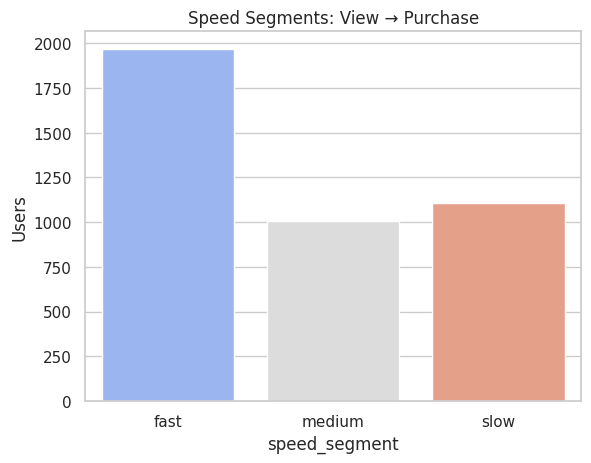

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

count = cart_purchase_users["speed_segment"].value_counts()

# Plot
sns.barplot(x=count.index, y=count.values, palette="coolwarm")
plt.ylabel("Users")
plt.title("Speed Segments: View → Purchase")
plt.show()

 Speed Segmentation Insights

Half of total users took 4 minutes to view and purchase the product, indicating strong purchase intent.

However, the other half of total users took longer to make this decision. The medium and slow type of users are likely  hesistant, seeking other options or confuse about the specific product

This suggest that even half users are fast converter, the are for improvement is still bigger. Business can add more enhancement like more detailed description, optimal pricing, visual aids that will help customer convert more to fast buyer

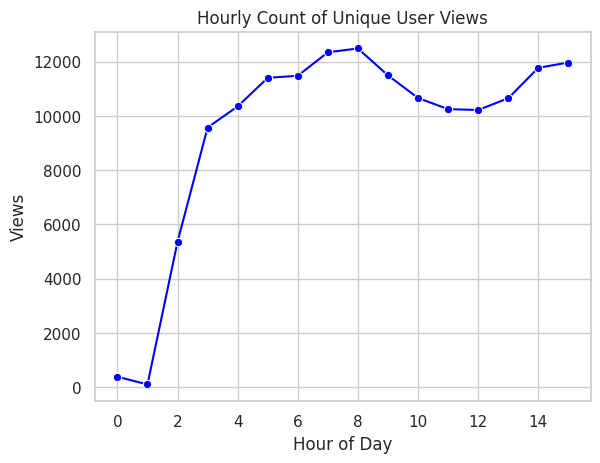

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

user_events['hour'] = user_events['view'].dt.hour

hourly_unique_views_count = user_events.groupby('hour')['view'].count()
sns.lineplot(x=hourly_unique_views_count.index, y=hourly_unique_views_count.values, marker='o', color='blue')

plt.title('Hourly Count of Unique User Views')
plt.xlabel('Hour of Day')
plt.ylabel('Views')
plt.grid(True)
plt.show()

From this graph, we can se that the highest peak of users that is actively viewing a proudtc is in the morning  around 5 am to 8 am and goes down a bit then users are active again in the afternoon 12-2pm.


### Conclusion

Time segmentation showed us about how does the customer feel or behave on the process of purchase.

We have seen that 48% of the users are fast paced buyers, means that these users are solid buyers with almost no hesitation while the other 24% are medium and 27% are slow paced customer.

This indicates that a huge count of customer still feel uncertainty about purchasing a product or not.

Also the huge drop of the numbers from the product that was viewed to  the product that was added to cart and purchased is alarming.

Only about 4.8% of the product that was viewed are being added to cart and 62% of product that was added to cart are being purchased. In total about 3% of product that was being viewed are being purchased.

This is a very low conversion number if we are going to take a broader aspect. This indicate that users are not convinced to purchased product rightaway.

Along with this the users are most active viewing the product in the morning 5am - 8 am and in the afternoon 12-2pm. Suggesting that users are looking to purchase before they start their day and while their lunch break

## Recommendation:

Based on the funnel and time-based analysis, the following product interventions are recommended:

**Strengthen the product view experience**

Marketing or media team should focus on clarity of the proudct, clear value propostion.


**Social Proof and More Exposure**

Showing more proof about being a legitimate seller can build the confidence of the buyer and ensuring quality products to have a better rating that can influence buyer decision making.

**Preserve checkout process**

Since cart-to-purchase conversion is relatively strong, the checkout experience should remain streamlined with minimal additional steps.

**Timely Marketing**
Marketing team can use the send out some marketing emails,voucher,live selling or ads on the time where users are active most. This can help to better attract viewers to purchase the product